# Séance 7 - *correction*

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("white")

from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier

## Données et préparation

In [3]:
import pandas

spotify = pandas.read_csv("https://fxjollois.github.io/donnees/spotify_dataset.csv")
spotify

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,decade
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.4900,0.000000,0.0779,0.8450,185.655,173533,3,32.94975,9,1,60s
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.0180,0.107000,0.1760,0.7970,101.801,213613,4,48.82510,10,0,60s
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.8460,0.000004,0.1190,0.9080,115.940,223960,4,37.22663,12,0,60s
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.7060,0.024600,0.0610,0.9670,105.592,157907,4,24.75484,8,0,60s
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.8570,0.000872,0.2130,0.9060,114.617,245600,4,21.79874,14,0,60s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41094,Lotus Flowers,Yolta,spotify:track:4t1TljQWJ6ZuoSY67zVvBI,0.172,0.358,9,-14.430,1,0.0342,0.8860,0.966000,0.3140,0.0361,72.272,150857,4,24.30824,7,0,10s
41095,Calling My Spirit,Kodak Black,spotify:track:2MShy1GSSgbmGUxADNIao5,0.910,0.366,1,-9.954,1,0.0941,0.0996,0.000000,0.2610,0.7400,119.985,152000,4,32.53856,8,1,10s
41096,Teenage Dream,Katy Perry,spotify:track:55qBw1900pZKfXJ6Q9A2Lc,0.719,0.804,10,-4.581,1,0.0355,0.0132,0.000003,0.1390,0.6050,119.999,227760,4,20.73371,7,1,10s
41097,Stormy Weather,Oscar Peterson,spotify:track:4o9npmYHrOF1rUxxTVH8h4,0.600,0.177,7,-16.070,1,0.0561,0.9890,0.868000,0.1490,0.5600,120.030,213387,4,21.65301,14,0,10s


Ici, nous enlevons les variables inutilisables telles que le nom du titre et de l'artiste, ainsi que l'URI. De plus, nous enlevons les trois variables (`key`, `time_signature` et `decades`) qualitatives. Nous les ajoutons en les encodant en *one-hot* (avec `OneHotEncoder`).

In [4]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [5]:
X = spotify.drop(["track", "artist", "uri", "key", "mode", "time_signature", 
                  "chorus_hit", "sections", "popularity", "decade"], axis = 1)

var_qual = ['key', 'time_signature', 'decade']
for v in var_qual:
    enc = encoder.fit(spotify[[v]])
    enc_df = pandas.DataFrame(enc.transform(spotify[[v]]).toarray(), columns = [v+":"+str(c) for c in enc.categories_[0]])
    X = pandas.concat([X, enc_df], axis = 1)

X

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,...,time_signature:1,time_signature:3,time_signature:4,time_signature:5,decade:00s,decade:10s,decade:60s,decade:70s,decade:80s,decade:90s
0,0.417,0.620,-7.727,0.0403,0.4900,0.000000,0.0779,0.8450,185.655,173533,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.498,0.505,-12.475,0.0337,0.0180,0.107000,0.1760,0.7970,101.801,213613,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.657,0.649,-13.392,0.0380,0.8460,0.000004,0.1190,0.9080,115.940,223960,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.590,0.545,-12.058,0.1040,0.7060,0.024600,0.0610,0.9670,105.592,157907,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.515,0.765,-3.515,0.1240,0.8570,0.000872,0.2130,0.9060,114.617,245600,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41094,0.172,0.358,-14.430,0.0342,0.8860,0.966000,0.3140,0.0361,72.272,150857,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41095,0.910,0.366,-9.954,0.0941,0.0996,0.000000,0.2610,0.7400,119.985,152000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41096,0.719,0.804,-4.581,0.0355,0.0132,0.000003,0.1390,0.6050,119.999,227760,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41097,0.600,0.177,-16.070,0.0561,0.9890,0.868000,0.1490,0.5600,120.030,213387,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
y = spotify["popularity"]
y

0        1
1        0
2        0
3        0
4        0
        ..
41094    0
41095    1
41096    1
41097    0
41098    0
Name: popularity, Length: 41099, dtype: int64

## Fonction permettant de voir rapidement les résultats d'un modèle

In [19]:
def results(m):
    print("Méthode :", m)
    print()
    print("Score : " + str(m.score(X,y)))
    fpr, tpr, th = roc_curve(y, pandas.DataFrame(m.predict_proba(X))[1])
    print("AUC : ", auc(fpr, tpr))
    print()
    print(pandas.crosstab(m.predict(X), y))
    
#results(m_tree)

## $k$-NN

In [8]:
r2 = []
roc_auc = []
vn = []
fn = []
fp = []
vp = []

k_val = (1, 2, 3, 4, 5, 10, 15, 20, 25, 30)
for k in k_val:
    m_knn = KNeighborsClassifier(n_neighbors = k).fit(X, y)
    r2 = r2 + [m_knn.score(X, y)]
    fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_knn.predict_proba(X))[1])
    roc_auc = roc_auc + [auc(fpr, tpr)]
    p = m_knn.predict(X) * 1
    vn = vn + [sum((1 - y) * (1 - p))]
    fn = fn + [sum((1 - y) * p)]
    fp = fp + [sum(y * (1 - p))]
    vp = vp + [sum(y * p)]
    
df = pandas.DataFrame({
    "variable": k_val,
    "rsquared": r2,
    "auc": roc_auc,
    "vrais_negatifs": vn,
    "faux_negatifs": fn,
    "faux_positifs": fp,
    "vrais_positifs": vp
})
df

,variable,rsquared,auc,vrais_negatifs,faux_negatifs,faux_positifs,vrais_positifs
0,1,0.999538,0.999538,20541,10,9,20539
1,2,0.793401,0.907365,20551,0,8491,12057
2,3,0.777561,0.853086,15461,5090,4052,16496
3,4,0.730650,0.821111,17687,2864,8206,12342
4,5,0.723740,0.798572,14021,6530,4824,15724
5,10,0.670552,0.740744,14527,6024,7516,13032
6,15,0.653374,0.715218,11850,8701,5545,15003
7,20,0.644006,0.702107,12733,7818,6813,13735
8,25,0.637315,0.693651,11198,9353,5553,14995
9,30,0.631670,0.686291,11911,8640,6498,14050


In [20]:
m_knn = KNeighborsClassifier(n_neighbors = 5).fit(X, y)
results(m_knn)

Méthode : KNeighborsClassifier()

Score : 0.7237402369887345
AUC :  0.7985719827644633

popularity      0      1
row_0                   
0           14021   4824
1            6530  15724


## Arbres de décisions

In [10]:
m_tree = DecisionTreeClassifier().fit(X, y)

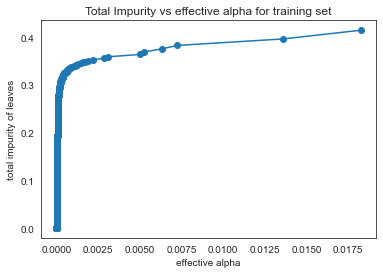

In [11]:
pruning = m_tree.cost_complexity_pruning_path(X, y)

fig, ax = plt.subplots()
ax.plot(pruning.ccp_alphas[:-1], pruning.impurities[:-1], marker="o") # , drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [12]:
m_tree_elague = DecisionTreeClassifier(ccp_alpha=0.0025).fit(X, y)

results(m_tree_elague)

Méthode : DecisionTreeClassifier(ccp_alpha=0.0025)

Score : 0.7441543589868367

popularity      0      1
row_0                   
0           13188   3152
1            7363  17396


## Réseaux de neurones

In [13]:
r2 = []
roc_auc = []
vn = []
fn = []
fp = []
vp = []

layers = ((), (10), (20), (50), (100), (10, 10), (20, 20), (50, 50), (100, 100), 
          (10, 10, 10), (20, 20, 20), (50, 50, 50), (100, 100, 100))
for l in layers:
    m_mlp = MLPClassifier(hidden_layer_sizes = l, max_iter = 1000).fit(X, y)
    r2 = r2 + [m_mlp.score(X, y)]
    fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_mlp.predict_proba(X))[1])
    roc_auc = roc_auc + [auc(fpr, tpr)]
    p = m_mlp.predict(X) * 1
    vn = vn + [sum((1 - y) * (1 - p))]
    fn = fn + [sum((1 - y) * p)]
    fp = fp + [sum(y * (1 - p))]
    vp = vp + [sum(y * p)]
    
df = pandas.DataFrame({
    "layers": layers,
    "rsquared": r2,
    "auc": roc_auc,
    "vrais_negatifs": vn,
    "faux_negatifs": fn,
    "faux_positifs": fp,
    "vrais_positifs": vp
})
df

,layers,rsquared,auc,vrais_negatifs,faux_negatifs,faux_positifs,vrais_positifs
0,(),0.500012,0.518968,20550,1,20548,0
1,10,0.494757,0.615901,19650,901,19864,684
2,20,0.545658,0.651942,1916,18635,38,20510
3,50,0.497822,0.557489,20455,96,20543,5
4,100,0.499964,0.500608,0,20551,0,20548
5,"(10, 10)",0.499964,0.500000,0,20551,0,20548
6,"(20, 20)",0.510183,0.619260,423,20128,3,20545
7,"(50, 50)",0.497092,0.536720,20425,126,20543,5
8,"(100, 100)",0.501302,0.583248,55,20496,0,20548
9,"(10, 10, 10)",0.499964,0.560660,0,20551,0,20548


In [21]:
m_mlp = MLPClassifier(hidden_layer_sizes=(20)).fit(X,y)

results(m_mlp)

Méthode : MLPClassifier(hidden_layer_sizes=20)

Score : 0.6017421348451301
AUC :  0.6751876793464068

popularity      0      1
row_0                   
0            4900    717
1           15651  19831


## Comparaison des modèles entre eux

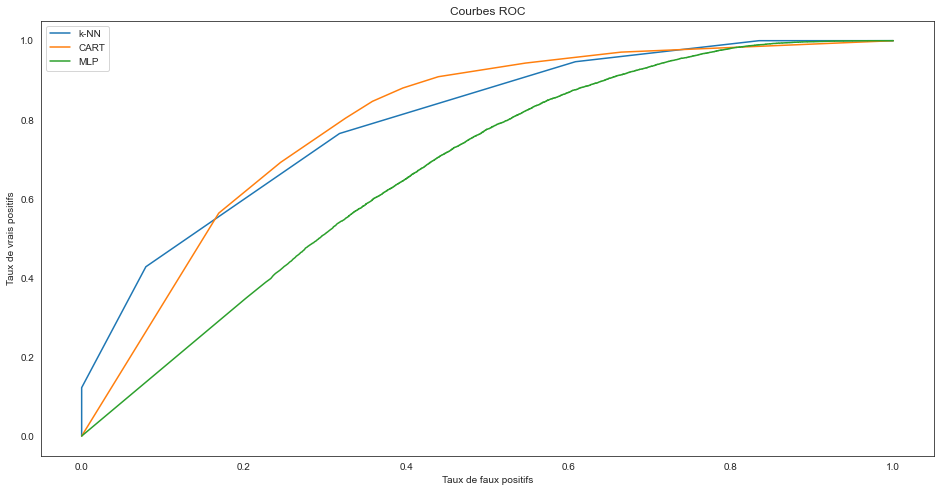

In [22]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 1, 1)
plt.title("Courbes ROC")

# kNN
fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_knn.predict_proba(X))[1])
ax.plot(fpr, tpr, label='k-NN')

# CART
fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_tree_elague.predict_proba(X))[1])
ax.plot(fpr, tpr, label='CART')

# MLP
fpr, tpr, th = roc_curve(y, pandas.DataFrame(m_mlp.predict_proba(X))[1])
ax.plot(fpr, tpr, label='MLP')

ax.legend()
ax.set(xlabel = "Taux de faux positifs", ylabel = "Taux de vrais positifs")
plt.show()